In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/")


In [9]:
!pip install chart_studio

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
import numpy as np
import gc
gc.enable()

%matplotlib inline

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)


In [0]:
# read the data
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')

In [4]:
train_identity

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,NaN,427.0,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,-300.0,New,NotFound,166.0,15.0,352.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.1.1,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,27.0,567.0,411.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,-300.0,Found,Found,166.0,15.0,352.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_9_5,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


In [9]:
train_transaction

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.000000,1758.000000,925.000000,0.0,354.000000,0.0,135.0,0.000000,0.000000,0.000000,50.0,1404.0,790.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0,47.950001,0.0,0.0,47.950001,47.950001,47.950001,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [11]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [14]:
# missing data
missing_values_count = train_transaction.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionID        0
isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
dtype: int64
% of missing data =  41.073431200111266


In [15]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
dtype: int64
% of missing data =  35.58109650830896


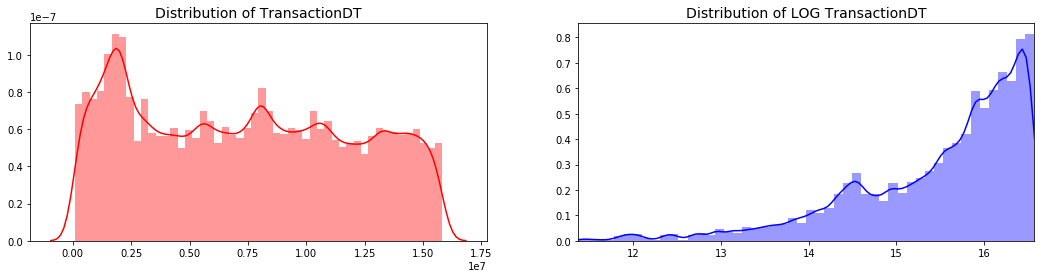

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionDT', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

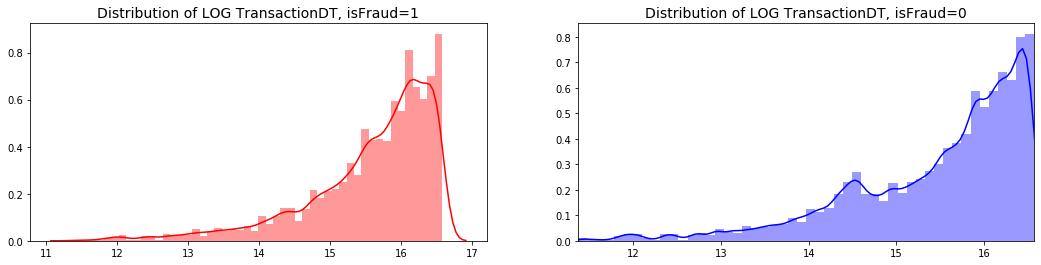

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionDT, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

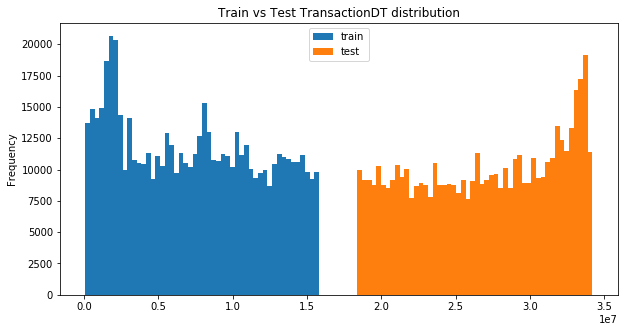

In [23]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(10, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

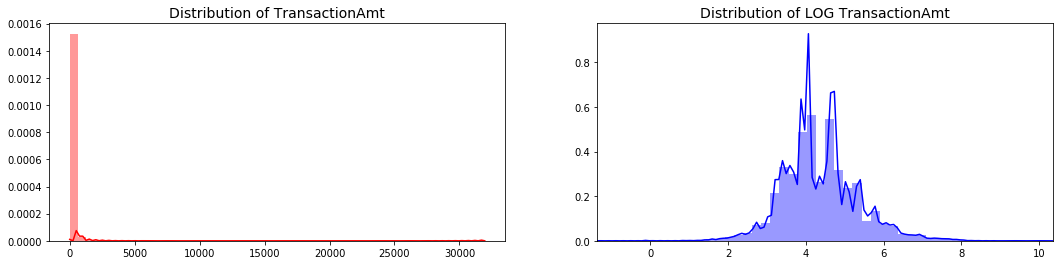

In [24]:
# transaction amount
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

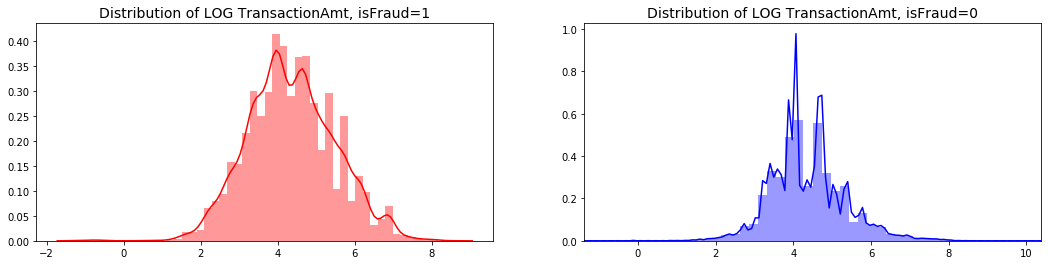

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionAmt, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

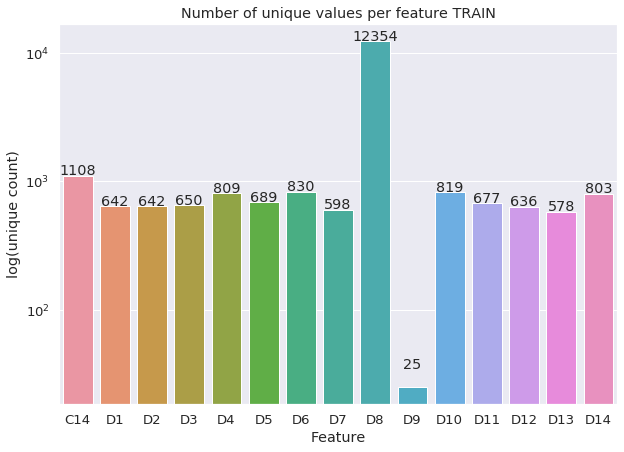

In [26]:
#D features
plt.figure(figsize=(10, 7))
d_features = list(train_transaction.columns[30:45])
uniques = [len(train_transaction[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 


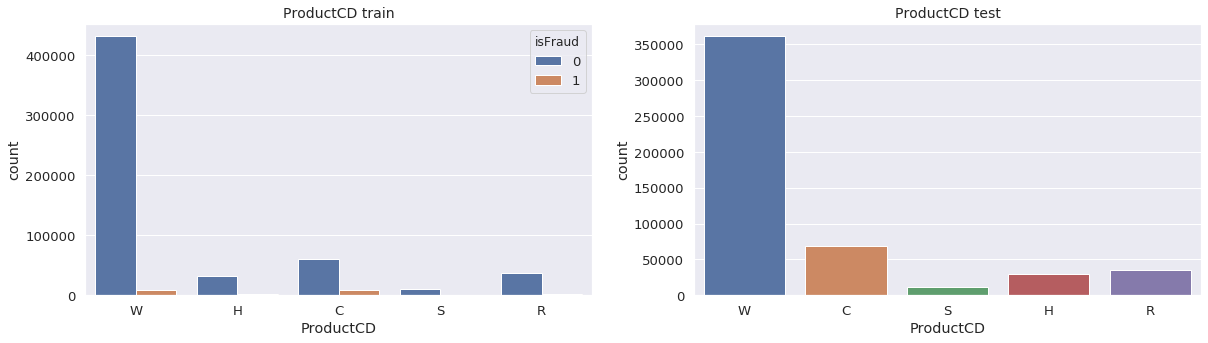

In [27]:
# product CD
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="ProductCD", ax=ax[0], hue = "isFraud", data=train_transaction)
ax[0].set_title('ProductCD train', fontsize=14)
sns.countplot(x="ProductCD", ax=ax[1], data=test_transaction)
ax[1].set_title('ProductCD test', fontsize=14)
plt.show()

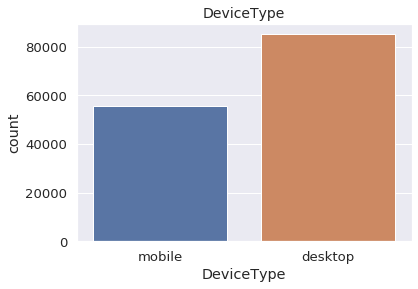

In [28]:
#Device type and information
ax = sns.countplot(x="DeviceType", data=train_identity)
ax.set_title('DeviceType', fontsize=14)
plt.show()

In [31]:
print ("Unique Devices = ",train_identity['DeviceInfo'].nunique())
train_identity['DeviceInfo'].value_counts().head()

Unique Devices =  1786


Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
Name: DeviceInfo, dtype: int64

In [33]:
print ("Unique Devices = ",train_identity['DeviceInfo'].nunique())
train_identity['DeviceInfo'].value_counts().head()

Unique Devices =  1786


Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
Name: DeviceInfo, dtype: int64

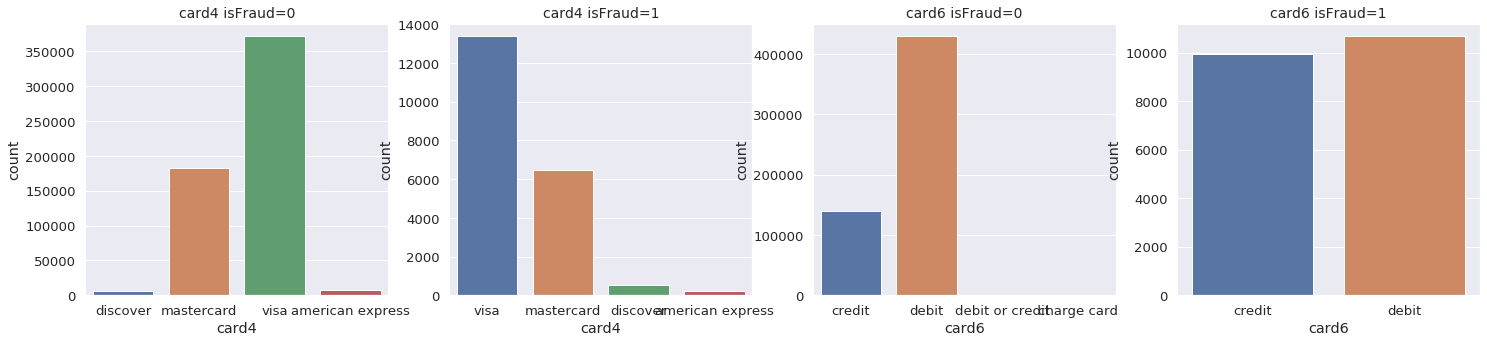

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

sns.countplot(x="card4", ax=ax[0], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[0].set_title('card4 isFraud=0', fontsize=14)
sns.countplot(x="card4", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('card4 isFraud=1', fontsize=14)
sns.countplot(x="card6", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('card6 isFraud=0', fontsize=14)
sns.countplot(x="card6", ax=ax[3], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[3].set_title('card6 isFraud=1', fontsize=14)
plt.show()
